# Project GIK2KM Group 12 - Movie Scraping, Clustering and Hypothesis Testing

Question: Does a movies rating correlate with the movies runtime?

## Exploratory analysis

In [2]:
import pandas as pd

# Import topRatedMovies dataset, delimiter is ';', convert genres and cast to a list
df_original = pd.read_csv('topRatedMovies.csv', delimiter=';', converters={
    "genres": lambda x: x.split("|"),
    "cast": lambda x: x.split("|")
})

df_original

,tmdb_id,title,year,runtime,rating,cast,genres
0,238,The Godfather,1972,175,87,"[Al Pacino, Marlon Brando, James Caan, Richard...","[Drama, Crime]"
1,278,The Shawshank Redemption,1994,142,87,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...","[Drama, Crime]"
2,240,The Godfather Part II,1974,202,86,"[Al Pacino, Robert Duvall, Diane Keaton, Rober...","[Drama, Crime]"
3,19404,Dilwale Dulhania Le Jayenge,1995,190,86,"[Shah Rukh Khan, Kajol, Amrish Puri, Anupam Kh...","[Comedy, Drama, Romance]"
4,424,Schindler's List,1993,195,86,"[Liam Neeson, Ben Kingsley, Ralph Fiennes, Car...","[Drama, History, War]"
...,...,...,...,...,...,...,...
995,63,Twelve Monkeys,1995,129,76,"[Bruce Willis, Madeleine Stowe, Brad Pitt, Chr...","[Science_Fiction, Thriller, Mystery]"
996,391698,The Beatles: Eight Days a Week - The Touring Y...,2016,106,76,"[Paul McCartney, Ringo Starr, John Lennon, Geo...","[Documentary, Music]"
997,228205,The Longest Ride,2015,128,76,"[Scott Eastwood, Britt Robertson, Lolita David...","[Drama, Romance]"
998,9912,The World's Fastest Indian,2005,127,76,"[Anthony Hopkins, Walton Goggins, Diane Ladd, ...","[Drama, Adventure, History]"


### Outliers Detection and Cleaning

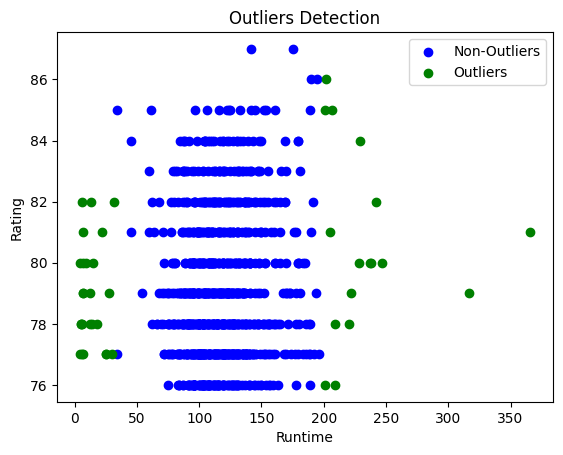

In [3]:
import matplotlib.pyplot as plt

# Always base the outlier detection on the original data so that new outliers won't be detected on multiple runs
df = df_original.copy()

# Select the columns to perform the clustering on
df_cluster = df[['runtime', 'rating']]

# Set the threshold for outlier detection, IQR * threshold
threshold = 2

# Calculate the IQR
Q1 = df_cluster.quantile(0.25)
Q3 = df_cluster.quantile(0.75)
IQR = Q3 - Q1

# Identify the outliers based on the threshold
outliers = ((df_cluster < (Q1 - threshold * IQR)) | (df_cluster > (Q3 + threshold * IQR))).any(axis=1)
outlier_ids = df.loc[outliers, 'tmdb_id']

# Plot the outliers
plt.scatter(df_cluster.loc[~outliers, 'runtime'], df_cluster.loc[~outliers, 'rating'], c='blue', label='Non-Outliers')
plt.scatter(df_cluster.loc[outliers, 'runtime'], df_cluster.loc[outliers, 'rating'], c='green', label='Outliers')

plt.xlabel('Runtime')
plt.ylabel('Rating')
plt.title('Outliers Detection')
plt.legend()
plt.show()

In [4]:
# Drop the rows with outlier IDs
df = df[~df['tmdb_id'].isin(outlier_ids)].reset_index(drop=True)

df

,tmdb_id,title,year,runtime,rating,cast,genres
0,238,The Godfather,1972,175,87,"[Al Pacino, Marlon Brando, James Caan, Richard...","[Drama, Crime]"
1,278,The Shawshank Redemption,1994,142,87,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...","[Drama, Crime]"
2,19404,Dilwale Dulhania Le Jayenge,1995,190,86,"[Shah Rukh Khan, Kajol, Amrish Puri, Anupam Kh...","[Comedy, Drama, Romance]"
3,424,Schindler's List,1993,195,86,"[Liam Neeson, Ben Kingsley, Ralph Fiennes, Car...","[Drama, History, War]"
4,129,Spirited Away,2001,125,85,"[Rumi Hiiragi, Miyu Irino, Mari Natsuki, Takas...","[Animation, Family, Fantasy]"
...,...,...,...,...,...,...,...
953,63,Twelve Monkeys,1995,129,76,"[Bruce Willis, Madeleine Stowe, Brad Pitt, Chr...","[Science_Fiction, Thriller, Mystery]"
954,391698,The Beatles: Eight Days a Week - The Touring Y...,2016,106,76,"[Paul McCartney, Ringo Starr, John Lennon, Geo...","[Documentary, Music]"
955,228205,The Longest Ride,2015,128,76,"[Scott Eastwood, Britt Robertson, Lolita David...","[Drama, Romance]"
956,9912,The World's Fastest Indian,2005,127,76,"[Anthony Hopkins, Walton Goggins, Diane Ladd, ...","[Drama, Adventure, History]"


### Normalize the data

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
normalized = scaler.fit_transform(df[['rating', 'runtime']])

normalized

array([[ 3.41079683,  2.26221443],
       [ 3.41079683,  0.97583327],
       [ 2.98063051,  2.84693314],
       ...,
       [-1.32103269,  0.43009581],
       [-1.32103269,  0.39111456],
       [-1.32103269, -0.19360415]])

### Find the optimal number of K

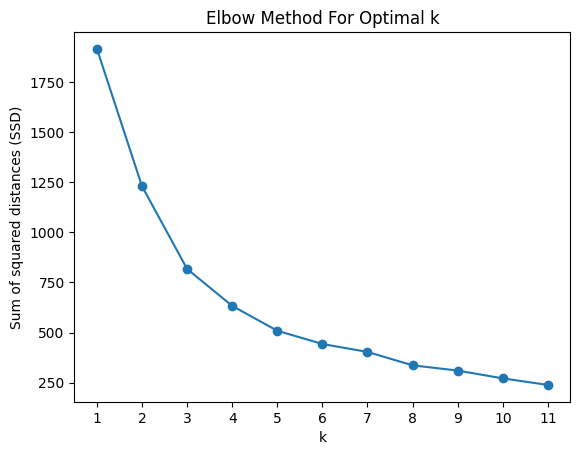

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate sum of squared distances
ssd = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(normalized)
    ssd.append(km.inertia_)
    
# Plot the elbow
plt.plot(K, ssd, 'o-')
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.show()

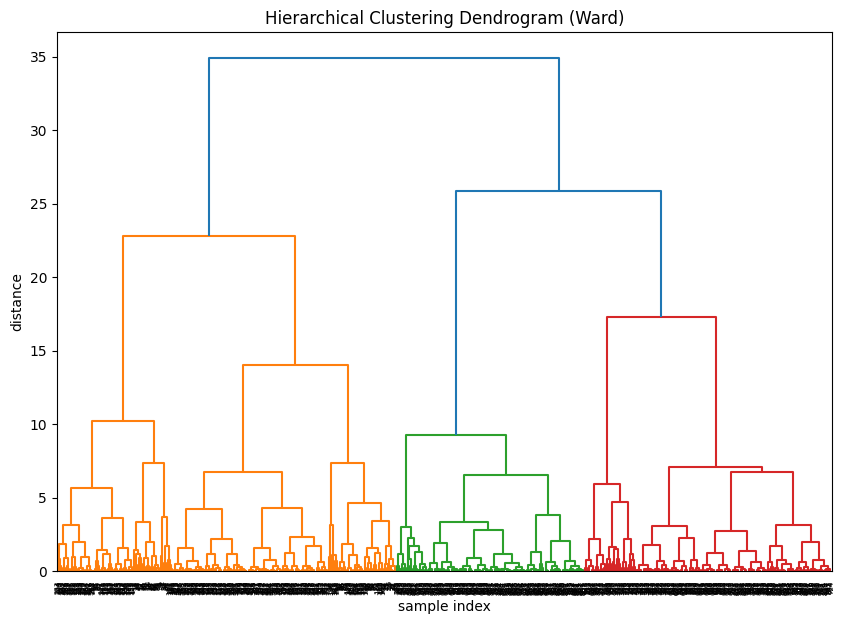

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Create a linkage matrix using ward's method
dend = linkage(normalized, 'ward')

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(dend)

plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

### Perform Clustering

In [8]:
# Perform clustering
n_clusters = 5

kmeans = KMeans(n_clusters, n_init='auto')
predictions = kmeans.fit_predict(normalized)

# Add the cluster column to the df
df['Cluster'] = predictions

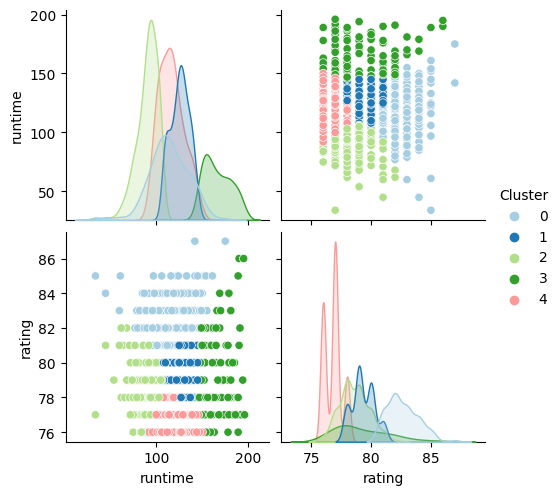

In [9]:
import seaborn as sns

# Plot the clusters
sns.pairplot(df, vars=df_cluster, hue='Cluster', palette='Paired')

In [10]:
# Print the runtime and rating statistics
print("******************************")
print("Runtime Data")
print("******************************")
print(df['runtime'].describe())
print("\n******************************")
print("Rating Data")
print("******************************")
print(df['rating'].describe())
print("******************************")


******************************
Runtime Data
******************************
count    958.000000
mean     116.966597
std       25.666760
min       34.000000
25%      100.000000
50%      114.000000
75%      131.000000
max      196.000000
Name: runtime, dtype: float64

******************************
Rating Data
******************************
count    958.000000
mean      79.070981
std        2.325896
min       76.000000
25%       77.000000
50%       79.000000
75%       81.000000
max       87.000000
Name: rating, dtype: float64
******************************


## Hypothesis Testing

### Check if runtime is normally distributed

H0 = Data is following a normal distribution  
H1 = Data is not following normal distribution

Result: Because p<0.05, we reject H0. The data is not normally distruted.
Statistic: 0.9778248071670532 P-value: 6.601657415172824e-11


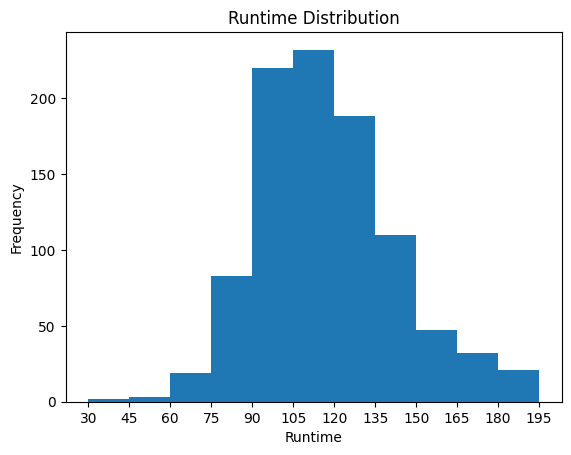

In [11]:
# Check if the data is normally distributed
from scipy.stats import shapiro

# Set the significance level
alpha = 0.05

# Run the Shapiro-Wilk test
stat, p = shapiro(df['runtime'])

# Print the result
if p < alpha:
    print('Result: Because p<0.05, we reject H0. The data is not normally distruted.')
else:
    print('Result: Because p>=0.05, we accept H0. The data is normally distruted.')

print("Statistic:", stat, "P-value:", p)

# Plot the histogram
fig, ax = plt.subplots()

bins = range(30, 200, 15)

ax.hist(df['runtime'], bins=bins)
ax.set_title('Runtime Distribution')
ax.set_xlabel('Runtime')
ax.set_xticks(bins)
ax.set_ylabel('Frequency')
plt.show()

In [12]:
# Randomly sort the DataFrame so that different movies around the median runtime
# isn't scewed towards a higher or lower rating in the next runtime sort step
df = df.sample(frac=1).reset_index(drop=True)

# Sort the DataFrame by runtime
df = df.sort_values(by='runtime').reset_index(drop=True)

# Split the DataFrame into 2 halves
df_runtime_short = df.iloc[:len(df) // 2]
df_runtime_long = df.iloc[len(df) // 2:].reset_index(drop=True)

#df_runtime_short
#df_runtime_long

In [13]:
# Mean rating for both halves
print("Mean Rating for Short Runtime", df_runtime_short['rating'].mean())
print("Mean Rating for Long Runtime", df_runtime_long['rating'].mean())

Mean Rating for Short Runtime 78.89979123173278
Mean Rating for Long Runtime 79.24217118997912


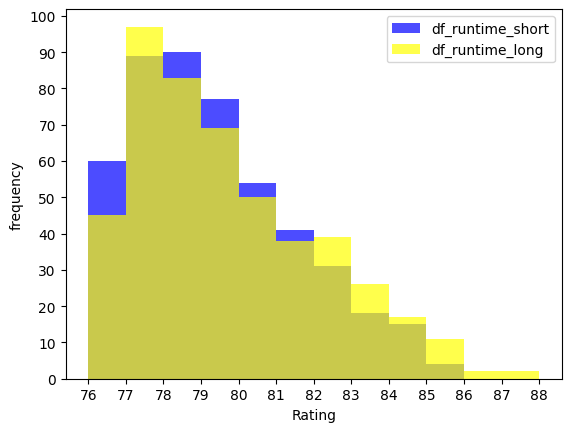

In [14]:
# Plot the movies in a histogram and compare the ratings based on runtime
fig, ax = plt.subplots()
bin = [76,77,78,79,80,81,82,83,84,85,86,87,88]

ax.hist(df_runtime_short['rating'], bins=bin, alpha=0.7, color='blue', label='df_runtime_short')
ax.hist(df_runtime_long['rating'], bins=bin, alpha=0.7, color='yellow', label='df_runtime_long')

ax.set_xlabel('Rating')
ax.set_xticks(bin)
ax.set_ylabel('frequency')
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])

ax.legend()

plt.show()

H0 = The mean rating for the movies in the shorter half is lower than the mean rating for the longer half.  
H1 = The mean rating for the movies in the shorter half is NOT lower than the mean rating for the longer half.

In [15]:
# Kruskal-Wallis test
from scipy.stats import kruskal

# Set the significance level
alpha = 0.05

# Run the Kruskal-Wallis test
stat, p = kruskal(df_runtime_short['rating'], df_runtime_long['rating'])

# Print the result
if p < alpha:
    print('Result: Because p<0.05, we reject H0. There is no measurable difference in rating between the movies.')
else:
    print('Result: Because p>=0.05, we accept H0. There is a measurable difference in rating between the movies.')

print("Statistic:", stat, "P-value:", p)

Result: Because p>=0.05, we accept H0. There is a measurable difference in rating between the movies.
Statistic: 3.1104343788348583 P-value: 0.07779221091390394
